#  Проект: объединение баз и нахождение выбросов

In [69]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# remove the limit on the number of displayed columns
pd.set_option('display.max_columns', None)

### 1. Чтение данных

In [70]:
# база с ценами конкурентов
pars_df = pd.read_excel('data/Data_TSUM.xlsx', sheet_name='Data_Parsing')

# внутренняя база компании
comp_df = pd.read_excel('data/Data_TSUM.xlsx', sheet_name='Data_Company')


In [71]:
#  Убедимся, что данные прочитаны корректно
print('Parsing data:')
display(pars_df.head())

print('Company data:')
display(comp_df.head())

Parsing data:


,brand,Category,producer_id,producer_color,price
0,Valentino,Shoes,aaaaa1111_11,black,167
1,Valentino,Shoes,aaaaa1111_12,black,188
2,Valentino,Shoes,aaaaa1111_13,black,184
3,Valentino,Shoes,aaaaa1111_14,bla//ck,196
4,Valentino,Shoes,aaaaa1111_15,bla\\ck,250


Company data:


,brand,Category,item_id,color_id,current price
0,Valentino,Shoes,aaaaa111111,black,247
1,Valentino,Shoes,aaaaa111112,black,161
2,Valentino,Shoes,aaaaa111113,black,234
3,Valentino,Shoes,aaaaa111114,black,167
4,Valentino,Shoes,aaaaa111115,black,153


### 2. Предобработка данных для объединения

Для объединения данных стоит использовать признак `producer_id` из таблицы `pars_df` и признак `item_id` из таблицы `comp_df`.  

В базе парсинга есть два id, однозначно определяющие товар: producer_id и producer_color.

В базе компании есть два аналогичных поля: item_id и color_id.  
Используем их для объединения.  

Для начала приведем данные к единой форме, а именно:  
- В признаке `producer_id` удалим символ нижнего подчеркивания 
- В признаке `producer_color` удалим следующие служебные символы: `_, -, ~, \\, //`  

In [72]:
pars_df.producer_color.value_counts()

~~~red      33
white_~     21
black        9
bla//ck      3
bla\\ck      3
bla__ck      3
bla\\c~k     3
Name: producer_color, dtype: int64

In [73]:
pars_df.producer_id.value_counts()

aaaaa1111_11    1
sssss1111_17    1
sssss1111_15    1
sssss1111_14    1
sssss1111_13    1
               ..
aaaaa1111_35    1
aaaaa1111_34    1
aaaaa1111_33    1
aaaaa1111_32    1
sssss1111_35    1
Name: producer_id, Length: 75, dtype: int64

In [74]:
def remove_special_symbols(s: str, symbols: list = None) -> str:
    """
    Функция очистки строкового значения от служебных символов
    типа '_', '-', '~', '\\', '//'.

    Args:
        s (str): переданное значение, строка. Может содержать:
            - только буквы, пример: black;
            - буквы и цифры, пример: aaaaa111112;
            - буквы с примесью служб.символов, пример: white_~
            - буквы и цифры с примесью служб.символов, пример: sssss1111_14
        symbols (list, optional): Список технических символов, подлежащих удалению из строки.
        Если равен None - то удаляются все символы кроме букв и чисел. Defaults to None.

    Returns:
        str: значение очищенное от спец.символов с сохранением последовательности букв и чисел.
    """
    # Проверим состоит ли строка только из цифр или букв
    if not s.isalnum():
        if symbols:
            return ''.join([char for char in s if char not in symbols])
        
        # if symbols list is None
        return ''.join([char for char in s if char.isalnum()])
    
    return s
    

In [75]:
technical_symbols = ['_', '-', '~', '\\', '/']

for col in ['producer_id', 'producer_color']:
    pars_df[col] = pars_df[col].apply(remove_special_symbols,
                                      symbols=technical_symbols
                                      )


Для удобства объединения данных приведем названия признаков к одинковые значениям.

In [76]:
pars_df.columns = ['brand', 'category', 'item_id', 'color', 'price']
comp_df.columns = ['brand', 'category', 'item_id', 'color', 'price']

### 3. Объединение данных

In [77]:
df = pars_df.merge(comp_df[['item_id', 'color', 'price']],
                   left_on=['item_id', 'color'],
                   right_on=['item_id', 'color'],
                   suffixes=('_pars', '_comp')
                   )
df.info()
display(df.head(3))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 74
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   brand       75 non-null     object
 1   category    75 non-null     object
 2   item_id     75 non-null     object
 3   color       75 non-null     object
 4   price_pars  75 non-null     int64 
 5   price_comp  75 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 4.1+ KB


,brand,category,item_id,color,price_pars,price_comp
0,Valentino,Shoes,aaaaa111111,black,167,247
1,Valentino,Shoes,aaaaa111112,black,188,161
2,Valentino,Shoes,aaaaa111113,black,184,234


### 4. Добавление нового признака

Добавление нового признака разницы цен в % (цена конкурента к нашей цене)

In [78]:
df['price_diff_percentage'] = np.round(df['price_pars'] / df['price_comp'] * 100, 2)

### 5. Определение сильных отклонений

Посмотрим какое кол-во уникальных значений содержат признаки `brand` и `category`

In [79]:
features = ['brand', 'category']
for feat in features:
    unique_values = df[feat].unique()
    # print(unique_values)
    print(f"feat. '{feat}', unique values: {len(unique_values)}: {unique_values}")

feat. 'brand', unique values: 3: ['Valentino' 'Brioni' 'Stone Island']
feat. 'category', unique values: 2: ['Shoes' 'Bags']


Посмотрим на сбалансированность классов в этих признаках

In [80]:
features = ['brand', 'category']
for feat in features:
    display(df[feat].value_counts(normalize=True))
    

Valentino       0.333333
Brioni          0.333333
Stone Island    0.333333
Name: brand, dtype: float64

Shoes    0.56
Bags     0.44
Name: category, dtype: float64

В целом классы более менее сбалансированны. 

#### Признак price_diff_percentage

Посмотрим на распределение признака в целом

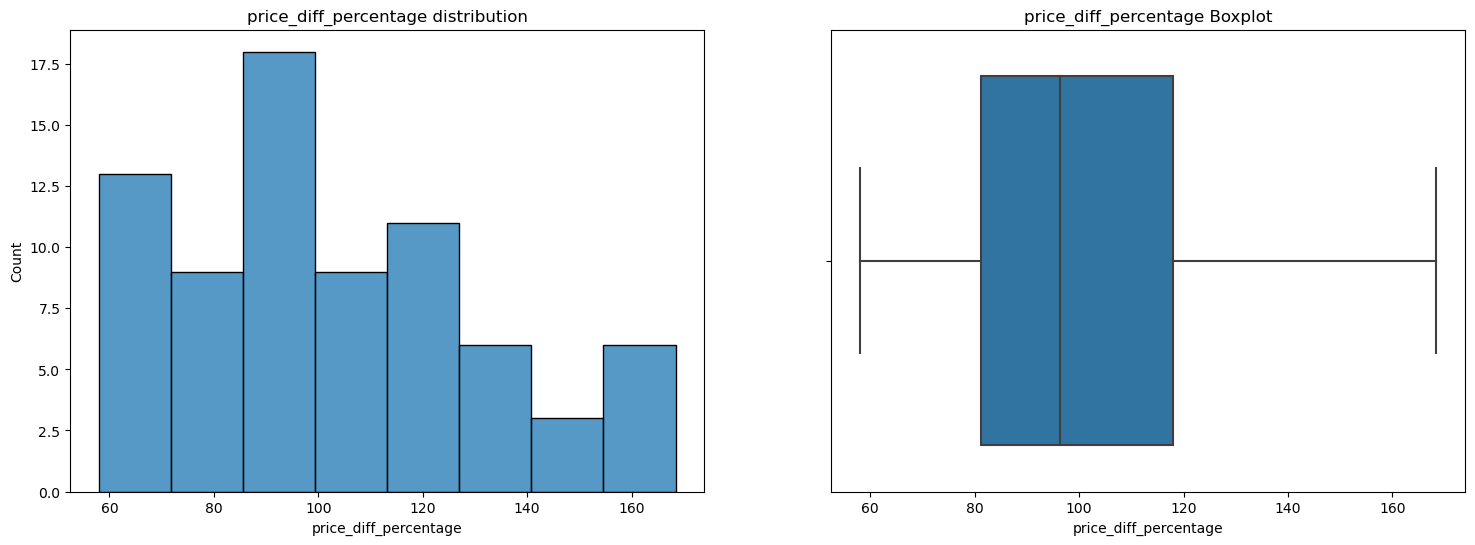

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
histplot1 = sns.histplot(data=df, x='price_diff_percentage', ax=axes[0,]);
histplot1.set_title('price_diff_percentage distribution');

boxplot1 = sns.boxplot(data=df, x='price_diff_percentage', ax=axes[1]);
boxplot1.set_title('price_diff_percentage Boxplot');

Сам признак имеет небольшой правый хвост.  Медиана находится на уровне 97. Самые частые наблюдения имеют значение признака в диапазоне от 82 до 118, что соответвует 25 и 75 квартилю.  

Посмотрим на распределение целевого признака `price_diff_percentage` в разрезе бренда

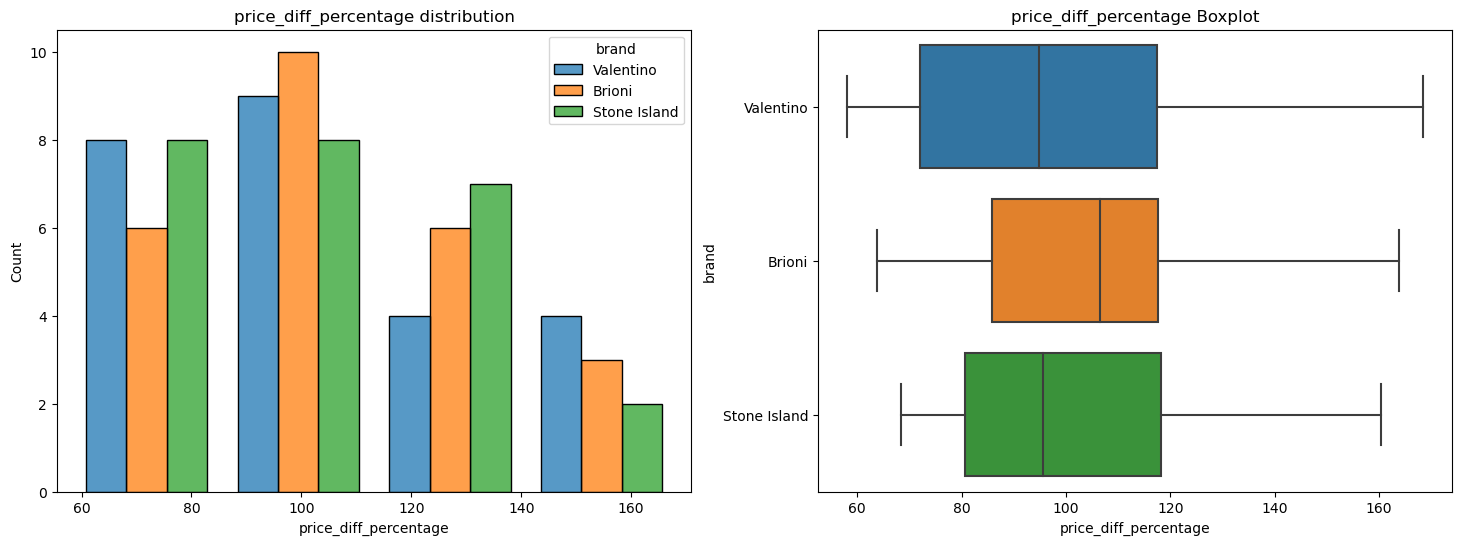

In [110]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
histplot = sns.histplot(data=df, x='price_diff_percentage', hue='brand', multiple="dodge", shrink=.8, bins=4, ax=axes[0]);
histplot.set_title('price_diff_percentage distribution');

boxplot = sns.boxplot(data=df, x='price_diff_percentage', y='brand', ax=axes[1]);
boxplot.set_title('price_diff_percentage Boxplot');

Из распределения видно, что в данных больше всего товаров с ценой в районе 90 - 110 и в районе 60-80.  
По ящикам с усами видно, бренд Valentino имеет самый большой разброс в разнице цен. Бренд Stone Island, наоборот, имеет меньший разброс значений, но равную первому бренду медиану.

Посмотрим на распределение целевого признака `price_diff_percentage` в разрезе категории.

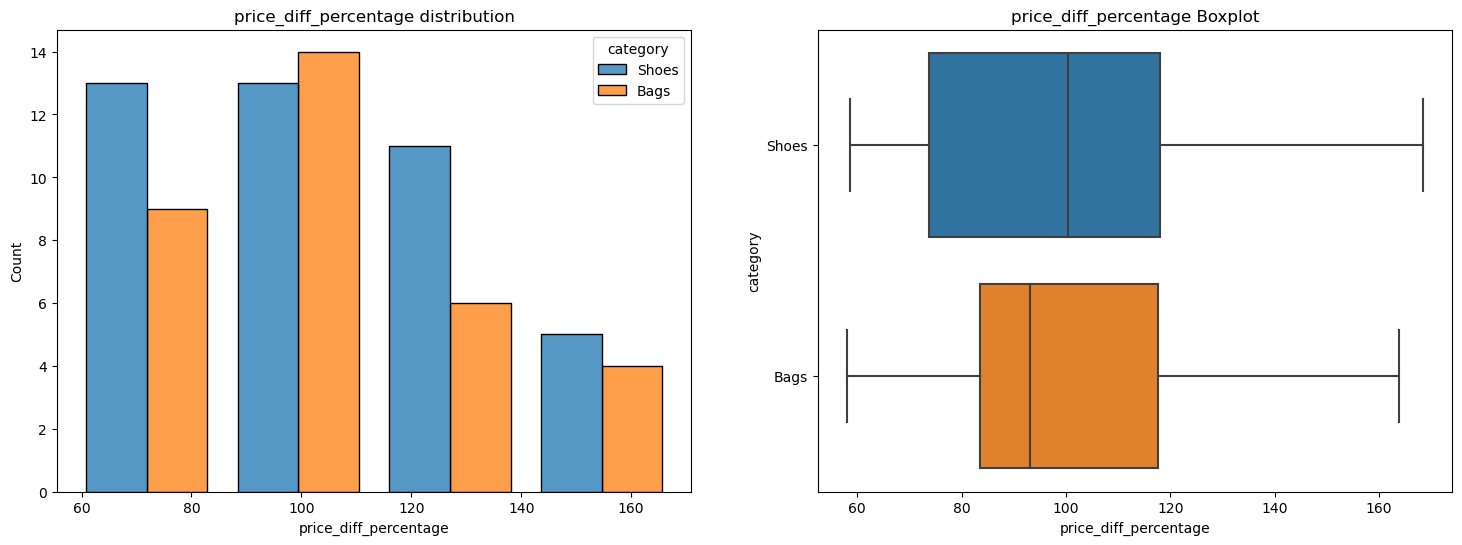

In [113]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
histplot = sns.histplot(data=df, x='price_diff_percentage', hue='category', multiple="dodge", shrink=.8, bins=4, ax=axes[0]);
histplot.set_title('price_diff_percentage distribution');

boxplot = sns.boxplot(data=df, x='price_diff_percentage', y='category', ax=axes[1]);
boxplot.set_title('price_diff_percentage Boxplot');


Самая частая разница в ценах наблюдается в диапазоне 90-110%. При этом разброс разницы значений в двух категориях почти одинаков, но чаще большая разница наблюдается в категории shoes.

Определить сильные отклонения от среднего в разности цен в пределах бренда-категории

In [114]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    
    return outliers, cleaned


outliers, cleaned = outliers_iqr_mod(df, 'price_diff_percentage', left=1.3, right=1.3)

print(f"Outliers count: {outliers.shape[0]}")

Outliers count: 1


Вся выборка имеет только один выброс, при этом критерий выброса был намеренно ужесточен до 1.3 межквартильного размаха.  
Посмотрим на выбросы в пределах бренда-категории.

In [115]:
from itertools import product

out_ind = np.array([], dtype='int64')

brands = df.brand.unique()
categories = df.category.unique()
for brand, category in product(brands, categories, repeat=1):
    cur_df = df[(df['brand'] == brand) & (df['category'] == category)]
    
    outliers, _ = outliers_iqr_mod(cur_df, 'price_diff_percentage', left=1.3, right=1.3)
    if outliers.shape[0]:
        out_ind = np.append(out_ind, list(outliers.index.values))

#  Посмотрим на определенные выбросы
display(df.iloc[out_ind])

,brand,category,item_id,color,price_pars,price_comp,price_diff_percentage
30,Brioni,Shoes,bbbbb111116,black,190,283,67.14
31,Brioni,Shoes,bbbbb111117,black,291,198,146.97
32,Brioni,Shoes,bbbbb111118,white,165,235,70.21
34,Brioni,Shoes,bbbbb111120,white,169,256,66.02
38,Brioni,Shoes,bbbbb111124,white,298,183,162.84
65,Stone Island,Bags,sssss111126,red,255,159,160.38


Как видно, в выбросы попали 5 товаров марки Brioni в категории Shoes, а так же 1 сумка марки Stone Island. 3 товара из 6 имеют высокую разницу в ценах и 3 низкую.

Принято решение удалить записи с выбросами из выборки.

In [116]:
df.drop(index=out_ind, inplace=True)

### 6. Запись в Excel файл

In [117]:
path_to_result = 'data/Data_TSUM_processed.xlsx'
df.to_excel(path_to_result,
            sheet_name='Combined_Data'
        )

### 7. Заключение

В рамках данного мини-проекта на очень небольшом наборе данных я отработал на практике такие важные для работы с данными навыки как:  
- Чтение и запись данных в Excel файл   
- Чистка данных  
- Слияние данных по ключу  
- Добавление новых признаков на основе имеющихся  
- Визуализация данных  
- Поиск и обработка выбросов  